In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import Sequence
import pandas as pd
import numpy as np
import math
import cv2
import os
from google.colab import files
import shutil
from google.colab.patches import cv2_imshow

In [2]:
# Upload files
print("Please upload the CSV file:")
uploaded_csv = files.upload()

Please upload the CSV file:


Saving labels_my-project-name_2024-10-16-05-22-11.csv to labels_my-project-name_2024-10-16-05-22-11 (1).csv


In [3]:
print("Please upload the images (as a zip file or individually):")
uploaded_images = files.upload()

Please upload the images (as a zip file or individually):


Saving Archive.zip to Archive (1).zip


In [4]:
# If the images are uploaded as a zip, unzip the file
if len(uploaded_images) == 1 and list(uploaded_images.keys())[0].endswith('.zip'):
    import zipfile
    with zipfile.ZipFile(list(uploaded_images.keys())[0], 'r') as zip_ref:
        zip_ref.extractall('/content/images/')
    image_folder_path = '/content/images'
else:
    # Otherwise, move the images to a folder
    os.makedirs('images', exist_ok=True)
    for filename, content in uploaded_images.items():
        with open(os.path.join('images', filename), 'wb') as f:
            f.write(content)
    image_folder_path = 'images/'

# Load the uploaded CSV file
csv_filename = list(uploaded_csv.keys())[0]
csv_file_path = f'/content/{csv_filename}'

def load_csv_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

# Load data from the CSV
data = load_csv_data(csv_file_path)

In [7]:
# Augmentation functions remain the same
def apply_random_rotation(image, bbox, max_angle=15):
    # Apply a random rotation
    angle = np.random.uniform(-max_angle, max_angle)
    rad_angle = math.radians(angle)

    # Rotation matrix and bounding box transformation logic
    image_center = (image.shape[1] / 2, image.shape[0] / 2)
    rotation_matrix = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    x_min, y_min, x_max, y_max = bbox
    box_points = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
    points_ones = np.hstack([box_points, np.ones((4, 1))])
    rotated_points = rotation_matrix.dot(points_ones.T).T

    x_min_rot, y_min_rot = rotated_points[:, 0].min(), rotated_points[:, 1].min()
    x_max_rot, y_max_rot = rotated_points[:, 0].max(), rotated_points[:, 1].max()
    rotated_bbox = [x_min_rot, y_min_rot, x_max_rot, y_max_rot]

    return rotated_image, rotated_bbox

def apply_random_shearing(image, bbox, max_shear=15):
    # Apply random shearing
    shear_x = np.random.uniform(-math.radians(max_shear), math.radians(max_shear))
    shear_y = np.random.uniform(-math.radians(max_shear), math.radians(max_shear))
    shear_matrix = np.array([[1, math.tan(shear_x), 0], [math.tan(shear_y), 1, 0]], dtype=np.float32)
    sheared_image = cv2.warpAffine(image, shear_matrix, (image.shape[1], image.shape[0]))

    x_min, y_min, x_max, y_max = bbox
    box_points = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
    points_ones = np.hstack([box_points, np.ones((4, 1))])
    sheared_points = shear_matrix.dot(points_ones.T).T

    x_min_shear, y_min_shear = sheared_points[:, 0].min(), sheared_points[:, 1].min()
    x_max_shear, y_max_shear = sheared_points[:, 0].max(), sheared_points[:, 1].max()
    sheared_bbox = [x_min_shear, y_min_shear, x_max_shear, y_max_shear]

    return sheared_image, sheared_bbox

# Data generator class for memory efficiency
class DataGenerator(Sequence):
    def __init__(self, dataframe, image_folder, batch_size=16, target_size=(512, 512), augment=True, shuffle=True):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) * 7 / self.batch_size))  # Each image generates 7 samples

    def __getitem__(self, index):
        # Generate batch indices
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.dataframe) * 7) #change here len(self.dataframe) * 7
        batch_indices = self.indices[start_idx : end_idx]
        # Generate batch data
        X, y = self.__data_generation(batch_indices)
        if X.shape != (self.batch_size, self.target_size[0], self.target_size[1], 3) :
            X = np.zeros((self.batch_size, self.target_size[0], self.target_size[1], 3))
            y = {'classification_output': np.zeros(self.batch_size), 'bbox_output': np.zeros((self.batch_size, 4))}

        return X, y

    def on_epoch_end(self):
        # Update indices after each epoch for shuffling
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
        images, class_labels, bboxes = [], [], []

        for idx in batch_indices:
            row = self.dataframe.iloc[idx]
            image_name = row['image_name']
            image_path = os.path.join(self.image_folder, image_name)
            label = 1 if row['label_name'] == 'empty-shelf' else 0

            # Load and preprocess the original image
            original_image, original_bbox = self.preprocess_image(image_path, row)

            # Append the original image and its label
            images.append(original_image)
            class_labels.append(label)
            bboxes.append(original_bbox)

            if self.augment:
                # Generate six augmented versions of each image
                aug_images, aug_bboxes = self.generate_augmented_versions(original_image, original_bbox)

                images.extend(aug_images)
                class_labels.extend([label] * 6)
                bboxes.extend(aug_bboxes)

        return np.array(images), {'classification_output': np.array(class_labels), 'bbox_output': np.array(bboxes)}

    def preprocess_image(self, image_path, bbox):
        # Load and resize image
        image = cv2.imread(image_path)
        original_height, original_width = image.shape[:2]

        # Normalize and resize bounding box
        x_min = bbox['bbox_x'] / original_width
        y_min = bbox['bbox_y'] / original_height
        x_max = (bbox['bbox_x'] + bbox['bbox_width']) / original_width
        y_max = (bbox['bbox_y'] + bbox['bbox_height']) / original_height
        resized_bbox = [x_min, y_min, x_max, y_max]

        # Resize image to target size and normalize pixel values
        image = cv2.resize(image, self.target_size).astype(np.float32) / 255.0

        return image, np.array(resized_bbox)

    def generate_augmented_versions(self, image, bbox):
        aug_images, aug_bboxes = [], []

        augmentations = [
            lambda img, box: apply_random_rotation(img, box, max_angle=15),
            lambda img, box: apply_random_rotation(img, box, max_angle=-15),
            lambda img, box: apply_random_shearing(img, box, max_shear=15),
            lambda img, box: apply_random_shearing(img, box, max_shear=-15),
            lambda img, box: apply_random_rotation(*apply_random_shearing(img, box, max_shear=15), max_angle=15),
            lambda img, box: apply_random_rotation(*apply_random_shearing(img, box, max_shear=-15), max_angle=-15),
        ]

        for aug in augmentations:
            aug_image, aug_bbox = aug(image.copy(), bbox.copy())
            aug_images.append(aug_image)
            aug_bboxes.append(aug_bbox)

        return aug_images, aug_bboxes

In [8]:
def build_base_cnn(input_tensor):
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)

    return x

def build_rcnn_model(input_shape):
    # Input tensor for the images
    input_tensor = Input(shape=input_shape)

    # Pass the input tensor through the base CNN
    base_cnn_output = build_base_cnn(input_tensor)

    # Binary classification head (sigmoid for empty class detection)
    classification_output = layers.Dense(1, activation='sigmoid', name="classification_output")(base_cnn_output)

    # Bounding box regression head (4 values for bounding box coordinates)
    bbox_output = layers.Dense(4, name="bbox_output")(base_cnn_output)

    # Create the final model
    model = models.Model(inputs=input_tensor, outputs=[classification_output, bbox_output])

    return model

def compile_rcnn_model(model):
    # Compile the model
    model.compile(
        optimizer='adam',
        loss={
            'classification_output': 'binary_crossentropy',  # Loss for binary classification
            'bbox_output': 'mean_squared_error'  # Loss for bounding box regression
        },
        metrics={
            'classification_output': 'accuracy'
        }
    )

# Assume input images are of shape 128x128x3 and we have 2 classes (empty or not empty)
#input_shape = (512, 512, 3)
#num_classes = 2

# Build and compile the RCNN model
#rcnn_model = build_rcnn_model(input_shape)
#compile_rcnn_model(rcnn_model)

# Train the model
#rcnn_model.fit(X_train,
#               {'classification_output': Y_train_class, 'bbox_output': Y_train_bbox},
#               epochs=20, batch_size=16)

# Load CSV data
#csv_file_path = 'path/to/your/csv_file.csv'
image_folder_path = '/content/images'
data = pd.read_csv(csv_file_path)

# Set parameters for the generator
batch_size = 16
target_size = (512, 512)

# Initialize data generator
train_generator = DataGenerator(dataframe=data, image_folder=image_folder_path, batch_size=batch_size, target_size=target_size)

# Compile the RCNN model
input_shape = (512, 512, 3)
rcnn_model = build_rcnn_model(input_shape)
compile_rcnn_model(rcnn_model)

# Train the model with the data generator
rcnn_model.fit(train_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


415/415 ━━━━━━━━━━━━━━━━━━━━ 123s 249ms/step - classification_output_accuracy: 1.0000 - loss: 0.6445
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 133s 265ms/step - classification_output_accuracy: 1.0000 - loss: 0.4797
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 104s 246ms/step - classification_output_accuracy: 1.0000 - loss: 0.3612
Epoch 4/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 103s 245ms/step - classification_output_accuracy: 1.0000 - loss: 0.2760
Epoch 5/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 109s 261ms/step - classification_output_accuracy: 1.0000 - loss: 0.2140
Epoch 6/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 143s 262ms/step - classification_output_accuracy: 1.0000 - loss: 0.1682
Epoch 7/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 104s 245ms/step - classification_output_accuracy: 1.0000 - loss: 0.1337
Epoch 8/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 143s 250ms/step - classification_output_accuracy: 1.0000 - loss: 0.1074
Epoch 9/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 110s 262ms/step - classification_output_accuracy: 1.0000 - loss: 0.0870
Epo

Please upload a test image:


Saving Anshuman Raina Image (2).jpg to Anshuman Raina Image (2) (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


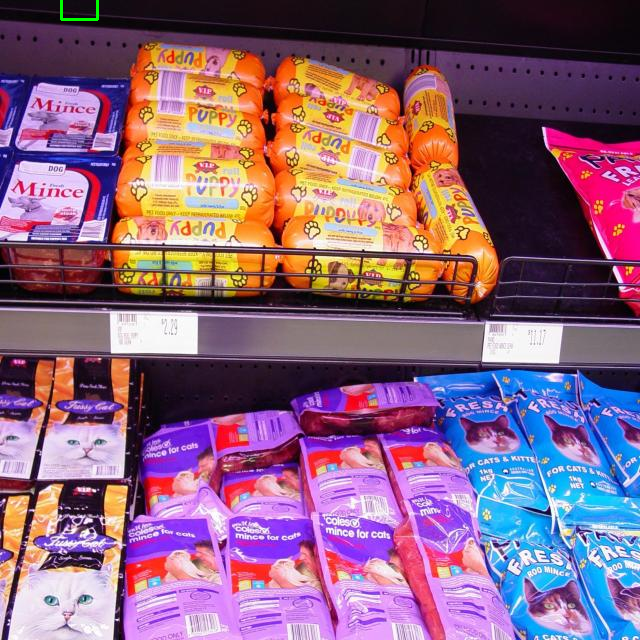

In [15]:
def predict_on_image(image_path, model, target_size=(512, 512)):
    # Preprocess the input image
    image = cv2.imread(image_path)
    original_height, original_width = image.shape[:2]
    resized_image = cv2.resize(image, target_size)
    resized_image = resized_image.astype(np.float32) / 255.0
    resized_image = np.expand_dims(resized_image, axis=0)  # Add batch dimension

    # Make predictions
    class_pred, bbox_pred = model.predict(resized_image)

    # Class prediction
    class_prob = class_pred[0, 0]  # Single output probability for "empty"
    label_name = 'empty' if class_prob > 0.3 else 'non-empty'

    # Bounding box prediction (denormalize the coordinates)
    x_min = int(bbox_pred[0, 0] * original_width)
    y_min = int(bbox_pred[0, 1] * original_height)
    x_max = int(bbox_pred[0, 2] * original_width)
    y_max = int(bbox_pred[0, 3] * original_height)

    #if label_name == 'empty':  # Only draw bounding box if classified as "empty"
        # Draw the predicted bounding box on the image
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(image, label_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the result
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example of using the model to predict on a new image
print("Please upload a test image:")
test_image = files.upload()
test_image_path = list(test_image.keys())[0]

# Predict on the new image
predict_on_image(test_image_path, rcnn_model)